# 04. Unsupervised Learning: Dimensionality Reduction & Clustering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

# Load processed data
try:
    df = pd.read_csv('data/processed/processed_data.csv')
    print(f"Dataset Shape: {df.shape}")
except FileNotFoundError:
    print("Processed data not found. Please run 01_Data_Preprocessing.ipynb first.")

# Prepare data for unsupervised learning
# Drop target variables and non-numeric columns if any
# We want to cluster based on engagement metrics and maybe some features
# Let's use the same features as classification but without the target
X = df.drop(columns=['Engagement_Rate', 'Engagement_Level_Encoded'])

# Identify numeric columns
numeric_cols = X.select_dtypes(include=[np.number]).columns
X_numeric = X[numeric_cols]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
print("Data Scaled.")

Dataset Shape: (5000, 36)
Data Scaled.


## 1. Dimensionality Reduction

Explained Variance Ratio: [0.23677672 0.17901693]


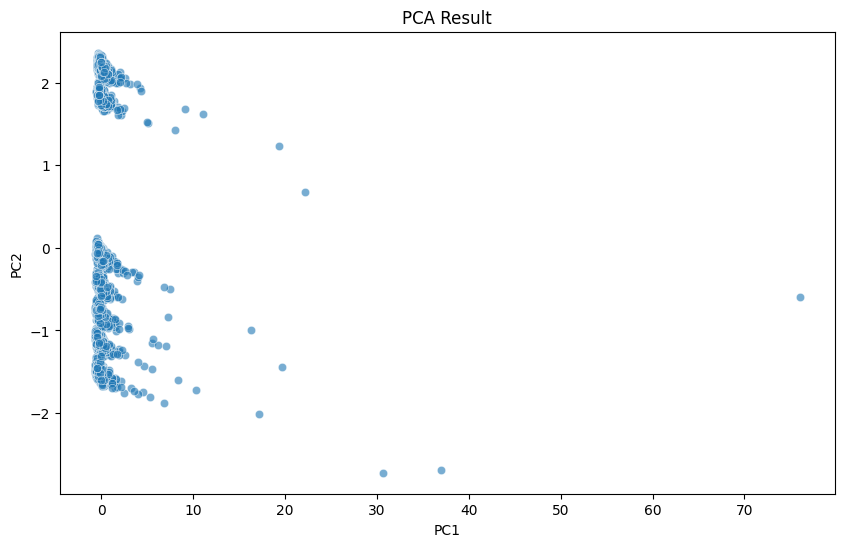

Running t-SNE...


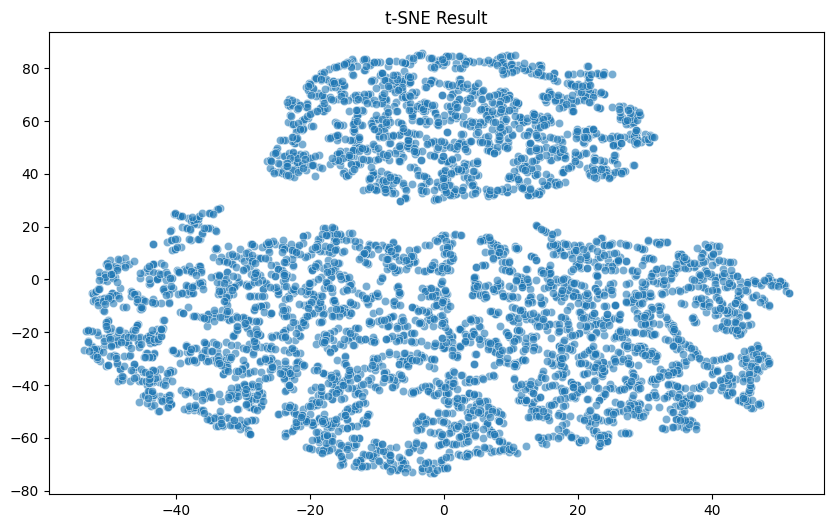

Running UMAP...
UMAP failed: module 'umap' has no attribute 'UMAP'


In [2]:
# 1. PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_scaled)
print(f"Explained Variance Ratio: {pca.explained_variance_ratio_}")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1], alpha=0.6)
plt.title('PCA Result')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# 2. t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=tsne_result[:,0], y=tsne_result[:,1], alpha=0.6)
plt.title('t-SNE Result')
plt.show()

# 3. UMAP
print("Running UMAP...")
try:
    reducer = umap.UMAP(random_state=42)
    umap_result = reducer.fit_transform(X_scaled)

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=umap_result[:,0], y=umap_result[:,1], alpha=0.6)
    plt.title('UMAP Result')
    plt.show()
except Exception as e:
    print(f"UMAP failed: {e}")
    umap_result = pca_result # Fallback for visualization

## 2. Clustering

Determining optimal K...


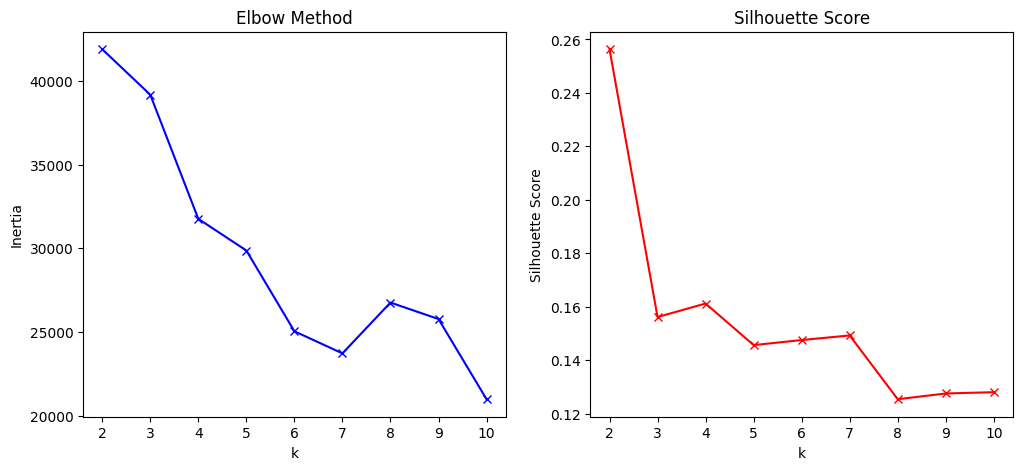

Using K=3


In [3]:
# Elbow Method
inertia = []
silhouette_scores = []
K = range(2, 11)

print("Determining optimal K...")
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')

plt.subplot(1, 2, 2)
plt.plot(K, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

# Optimal K (e.g., 3 or 4 based on plot, let's pick 3 for now or automate)
optimal_k = 3 # You can adjust this based on the plots
print(f"Using K={optimal_k}")
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)
df['Cluster_KMeans'] = kmeans_labels

Running DBSCAN...


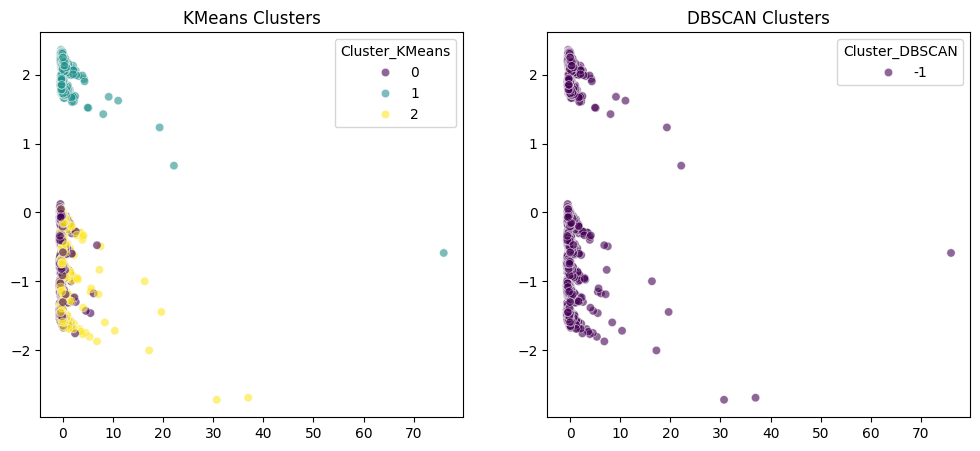

In [4]:
# DBSCAN
print("Running DBSCAN...")
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)
df['Cluster_DBSCAN'] = dbscan_labels

# Visualize Clusters on UMAP (or PCA if UMAP failed)
embedding = umap_result if 'umap_result' in locals() else pca_result

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['Cluster_KMeans'], palette='viridis', alpha=0.6)
plt.title('KMeans Clusters')

plt.subplot(1, 2, 2)
sns.scatterplot(x=embedding[:,0], y=embedding[:,1], hue=df['Cluster_DBSCAN'], palette='viridis', alpha=0.6)
plt.title('DBSCAN Clusters')
plt.show()

## 3. Cluster Analysis

KMeans Cluster Analysis:
                Engagement_Rate          Likes        Shares      Comments
Cluster_KMeans                                                            
0                     33.980840  249500.611111  50473.289562  12605.097082
1                     69.961192  246414.763251  51191.741343  24872.419788
2                     68.913097  257397.764836  50037.767055  37041.160288


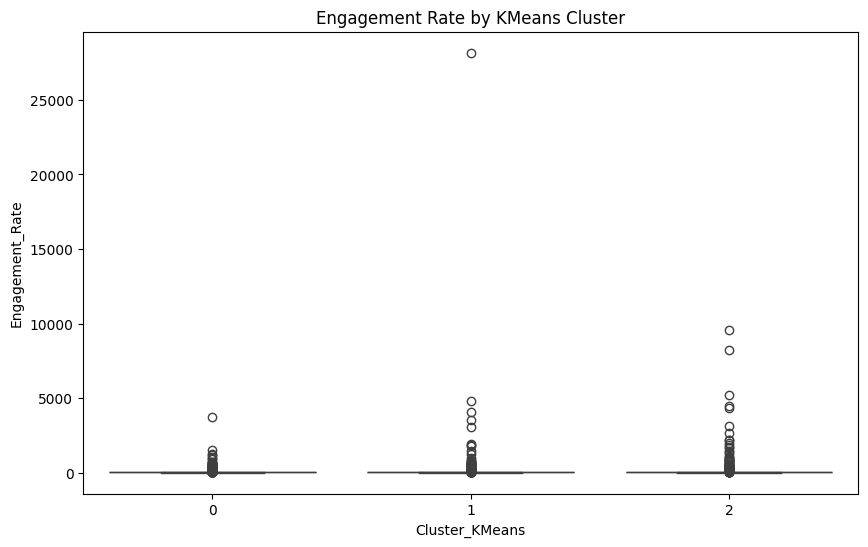

In [5]:
# Analyze Clusters
print("KMeans Cluster Analysis:")
# Group by cluster and calculate mean of key metrics
metrics = ['Engagement_Rate', 'Likes', 'Shares', 'Comments']
print(df.groupby('Cluster_KMeans')[metrics].mean())

# Boxplots for Engagement Rate by Cluster
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster_KMeans', y='Engagement_Rate', data=df)
plt.title('Engagement Rate by KMeans Cluster')
plt.show()